#### Libraries

In [1]:
import copy, time
import random
import pdb

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal

In [2]:
from IPython import display
matplotlib.rcParams['figure.figsize'] = [26,8]

In [3]:
from utils.utils import *

#### Model

In [4]:
def kronecker(A, B):
    '''Output is outer (kronecker) product'''
    (n, m), (k, l) = A.shape, B.shape
    out = torch.ger(A.reshape(-1), B.reshape(-1))
    out = out.reshape(n, m, k, l).permute([0,2,1,3]).reshape(n*k, m*l)
    return out

In [12]:
class SingleLayerNet(nn.Module):
    def __init__(self):
        super(SingleLayerNet, self).__init__()
        
        # Network structure (note: we store u^{1/2}, v^{1/2})
        self.w1_m = nn.Parameter(torch.zeros(1,10))
        self.w1_u = nn.Parameter( torch.eye(1)  ) # torch.randn(1) )  # 
        self.w1_v = nn.Parameter( torch.eye(10) ) # torch.randn(10) ) # 
        
        self.b1_m = nn.Parameter(torch.zeros(1,10))
        self.b1_u = nn.Parameter( torch.eye(1)  )  # torch.randn(1) )  #torch.eye(1)  ) 
        self.b1_v = nn.Parameter( torch.eye(10) )  # torch.randn(10) )  #torch.eye(10) ) 
        
        self.w2_m = nn.Parameter(torch.zeros(1, 10)) # --> to be swapped in inference
        self.w2_u = nn.Parameter( torch.eye(1)  )  # torch.randn(10) )  #torch.eye(10) ) 
        self.w2_v = nn.Parameter( torch.eye(10) )  # torch.randn(1) )  #torch.eye(1)  ) 
        
        self.b2_m = nn.Parameter(torch.zeros(1,1))
        self.b2_u = nn.Parameter( torch.eye(1)  )  # torch.randn(1) )  #torch.eye(1)  ) 
        self.b2_v = nn.Parameter( torch.eye(1) )  # torch.randn(1) )  #torch.eye(1)  ) 
        
    def prior(self, w1, b1, w2, b2):
        p_w1 = Normal(0,4).log_prob(w1)
        p_b1 = Normal(0,4).log_prob(b1)
        p_w2 = Normal(0,4).log_prob(w2)
        p_b2 = Normal(0,4).log_prob(b2)
        return p_w1.sum() + p_b1.sum() + p_w2.sum() + p_b2.sum()

    def mvn_(self, m, u, v, eps=0.1):
        # kronecker(u @ u.t(), v @ v.t())) # torch.diag(torch.rand(10))*eps
        # return MultivariateNormal(m, torch.diag(torch.nn.functional.softplus(u[:,0]))) 
        # u, v = torch.diag(u), torch.diag(v)
        return MultivariateNormal(m, kronecker(u @ u.t(), v @ v.t())) # + torch.diag(torch.rand(m.size()) * 0.01) )
    
    def get_q(self):
        q_w1 = self.mvn_(self.w1_m, self.w1_u, self.w1_v)
        q_b1 = self.mvn_(self.b1_m, self.b1_u, self.b1_v)
        q_w2 = self.mvn_(self.w2_m, self.w2_u, self.w2_v)
        q_b2 = self.mvn_(self.b2_m, self.b2_u, self.b2_v)
        return q_w1, q_b1, q_w2, q_b2

    def sample(self, q_w1, q_b1, q_w2, q_b2):
        return q_w1.rsample(), q_b1.rsample(), q_w2.rsample(), q_b2.rsample()
        
    def log_q(self, q_w1, q_b1, q_w2, q_b2, w1, b1, w2, b2):
        q_w1_log_prob = q_w1.log_prob(w1).sum()
        q_b1_log_prob = q_b1.log_prob(b1).sum()
        q_w2_log_prob = q_w2.log_prob(w2).sum()
        q_b2_log_prob = q_b2.log_prob(b2).sum()
        return q_w1_log_prob + q_b1_log_prob + q_w2_log_prob + q_b2_log_prob
            
    def forward(self, x, w1, b1, w2, b2):
        x = x @ w1 + b1
        x = torch.exp(-x*x) 
        x = x @ w2.t() + b2
        return x

In [13]:
def MVG(x, y, model, optimizer, num_samples=50, epochs=int(1e5), seed=None, print_every=500):
    '''Performs black-box variational inference'''
    torch.manual_seed(seed if seed else random.randint(0,1000))
        
    # Track ELBO statistics
    elbo_meter = AverageMeter(100)
    elbo_hist = []
    best_elbo = -1e6
    
    for ix_e in range(epochs):
        for ix_s in range(num_samples):

            # Get q distribution
            q_w1, q_b1, q_w2, q_b2 = model.get_q()
            
            # Sample weights
            w1, b1, w2, b2 = model.sample(q_w1, q_b1, q_w2, q_b2)
                        
            # Likelihood
            y_hat = model.forward(x, w1, b1, w2, b2)
            log_l = Normal(y_hat.squeeze(), 0.1 * torch.ones(6)).log_prob(y.squeeze()).sum()
            
            # Prior and complexity
            log_p = model.prior(w1, b1, w2, b2)
            log_q = model.log_q(q_w1, q_b1, q_w2, q_b2, w1, b1, w2, b2)
                        
            # ELBO = log likelihood + log p - log q
            elbo = (log_l + log_p - log_q).squeeze()
            loss = - elbo / num_samples
            
            # Store gradients
            optimizer.zero_grad()
            loss.backward()
                
            # Update ELBO statistics
            elbo_meter.update(elbo.item())
            elbo_hist.append(elbo.item())
        
        # Step gradient
        optimizer.step()
        
        # Print statistics
        if print_every > 0 and ix_e % print_every == print_every // 10: 
            new_best = False # elbo > best_elbo
            if new_best:
                best_elbo = elbo
                torch.save(model.state_dict(), 'model.pth')
            print('{:5d} | ELBO {:6.0f} | Rolling: {:6.0f} \t {}'.format(
                ix_e, elbo_meter.avg, elbo_meter.roll_avg, '(best)' if new_best else ''))
                
    return model, elbo_meter.roll_avg, elbo_hist

In [17]:
# Data and prediction range
X = torch.tensor([-2.0,-1.8,-1.0,1,1.8,2]).reshape(-1,1)
Y = - X*X*X*X + 3*X*X + 1
X_range = torch.arange(-5,5,0.05).reshape(-1,1)

# Model and optimization with many random restarts
# model = SingleLayerNet()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
model, elbo, hist = MVG(X, Y, model, optimizer, num_samples=1, print_every=200, epochs=int(3e4))
# print('\nChanging learning rate to 1e-5\n')
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
# model, elbo, hist = MVG(X, Y, model, optimizer, num_samples=2, print_every=100, epochs=int(3e4))

   20 | ELBO   -411 | Rolling:   -411 	 
  220 | ELBO   -407 | Rolling:   -406 	 
  420 | ELBO   -406 | Rolling:   -405 	 
  620 | ELBO   -405 | Rolling:   -403 	 
  820 | ELBO   -404 | Rolling:   -401 	 
 1020 | ELBO   -403 | Rolling:   -400 	 
 1220 | ELBO   -402 | Rolling:   -398 	 
 1420 | ELBO   -402 | Rolling:   -398 	 
 1620 | ELBO   -401 | Rolling:   -396 	 
 1820 | ELBO   -400 | Rolling:   -394 	 
 2020 | ELBO   -400 | Rolling:   -395 	 
 2220 | ELBO   -399 | Rolling:   -392 	 
 2420 | ELBO   -399 | Rolling:   -393 	 
 2620 | ELBO   -398 | Rolling:   -392 	 
 2820 | ELBO   -398 | Rolling:   -393 	 
 3020 | ELBO   -397 | Rolling:   -390 	 
 3220 | ELBO   -397 | Rolling:   -388 	 
 3420 | ELBO   -396 | Rolling:   -388 	 
 3620 | ELBO   -396 | Rolling:   -388 	 
 3820 | ELBO   -395 | Rolling:   -386 	 
 4020 | ELBO   -395 | Rolling:   -387 	 
 4220 | ELBO   -395 | Rolling:   -385 	 
 4420 | ELBO   -394 | Rolling:   -385 	 
 4620 | ELBO   -394 | Rolling:   -386 	 
 4820 | ELBO   -

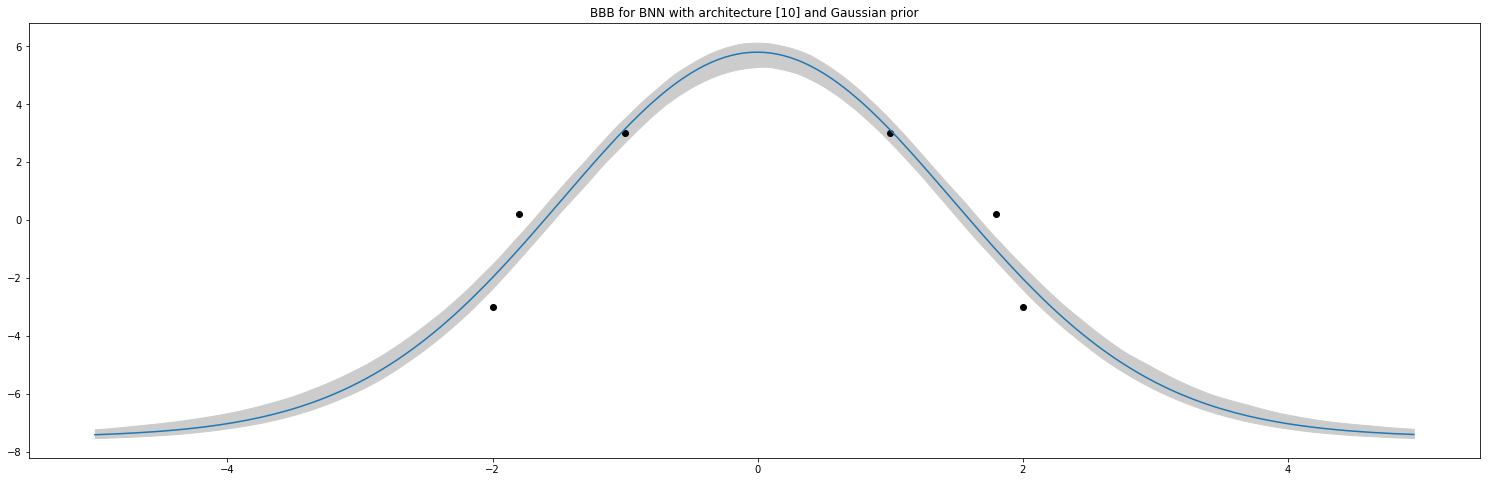

In [18]:
# Sample
preds = []
q_w1, q_b1, q_w2, q_b2 = model.get_q()
for _ in range(1000):
    w1, b1, w2, b2 = model.sample(q_w1, q_b1, q_w2, q_b2)
    pred = model(X_range, w1, b1, w2, b2)
    preds.append(to_numpy(pred))
    
# Plot
preds = np.concatenate(preds, axis=1)
bounds = (np.sort(preds, axis=1)[:, 5], np.sort(preds, axis=1)[:,-5])
mean = np.mean(preds, axis=1)
plt.gca().set_title('BBB for BNN with architecture [10] and Gaussian prior')
plt.gca().fill_between(X_range.reshape(-1), bounds[1], bounds[0], color="#cccccc")
plt.scatter(X, Y, color='black', marker='o')
plt.plot(to_numpy(X_range), mean)
plt.show() # plt.axis([-5,5,-8,8])

####  Scrap code

In [ ]:
# # layers = [1,10,10,1]
# total = 0
# ws = []
# bs = []
# ptr = 0
# for i in range(len(layers)-1):
#     ws.append([ptr, ptr + layers[i] * layers[i+1]])
#     ptr = ptr + layers[i] * layers[i+1]
#     bs.append([ptr, ptr + layers[i+1]])
#     ptr = ptr + layers[i+1]
# #     total += layers[i] * layers[i+1] + 1 * layers[i+1]
# print(ptr)
# # for w, b in zip(ws, bs):
# #     print('W: ', w, ' | B: ', b)
# #     print()
# # print('Total: ', total)

In [1]:
# class FlatNet(nn.Module):
#     def __init__(self, layers):
#         super(FlatNet, self).__init__()
#         self.layers = layers
#         self.W_ids = [] # will hold indices of weights
#         self.B_ids = [] # will hold incides of biases
        
#         # Count total number of parameters and split into weights, biases
#         ptr = 0 # current parameter
#         for i in range(len(layers)-1):
#             w_size = layers[i] * layers[i+1]
#             b_size = layers[i+1]
#             self.W_ids.append([ptr, ptr + w_size])
#             self.B_ids.append([ptr + w_size, ptr + w_size + b_size])
#             ptr += w_size + b_size
#         self.N = ptr # total number of parameters    
        
#         # Create and initialize parameters
#         self.lambdas = nn.Parameter(torch.zeros(2 * self.N))
#         self.lambdas.data[:self.N].fill_(0.0) # means
#         self.lambdas.data[self.N:].fill_(0.4) # log standard deviations
        
#     def get_means(self):
#         return self.lambdas[:self.N]

#     def get_stdvs(self):
#         return F.softplus(model.lambdas[self.N:])

#     def forward(self, x, sample):
#         '''Unroll network and forward pass'''
#         dim = 1
#         for i in range(len(self.W_ids)):
#             w = sample[self.W_ids[i][0]:self.W_ids[i][1]].reshape(dim, -1)
#             b = sample[self.B_ids[i][0]:self.B_ids[i][1]].reshape(1,-1)
#             dim = w.shape[1]
            
#             x = x @ w + b
#             x = torch.exp(-x*x) if i != len(self.W_ids)-1 else x
            
#         return x

In [ ]:
# # Calculate means and standard deviations of gradient updates
# gs = []
# for m in range(100):
#     model = FlatNet([1,10,1])
#     optimizer = torch.optim.SGD([model.lambdas], lr=1e-4)
#     model, elbo, hist = BBB(X, Y, model, optimizer, print_every=-1, num_samples=100, epochs=int(1))
#     gs.append(model.lambdas.grad)
# gs = torch.stack(gs, dim=1)
# for w in [1,5,7,15,21,30]:
#     print('{:+5.4f} | {:+5.4f}'.format(gs[w].mean().item(), gs[w].std().item()))

In [ ]:
# # Plot the ELBO
# plt.title('ELBO vs Iteration')
# plt.xlabel('Iteration')
# plt.ylabel('ELBO')
# plt.plot(best_hist)

In [ ]:
# # Sample from distribution over networks
# model = best_model
# preds = [model(X_range, Normal(model.get_means(), model.get_stdvs()).sample()) for _ in range(1000)]
# preds = np.concatenate(preds, axis=1)
# bounds = (np.sort(preds, axis=1)[:, 5], np.sort(preds, axis=1)[:,-5])
# mean = np.mean(preds, axis=1)

# # Plot
# plt.gca().set_title('BBB for BNN with architecture [10] and Gaussian prior')
# plt.gca().fill_between(X_range.reshape(-1), bounds[1], bounds[0], color="#cccccc")
# plt.scatter(X, Y, color='black', marker='o')
# plt.plot(to_numpy(X_range), mean)
# plt.show() # plt.axis([-5,5,-8,8])

In [ ]:
# # Model and optimization with many random restarts
# best_elbo = -1000
# best_hist = None
# best_model = None
# random_restarts = 20
# for _ in range(random_restarts):
#     model = FlatNet([1,10,1])
#     lr = (torch.randn(1)*3e-5 + 1e-4).item() # random learning rate
#     print('Learning rate: ', lr)
#     optimizer = torch.optim.SGD([model.lambdas], lr=lr)
#     model, elbo, hist = BBB(X, Y, model, optimizer, print_every=4000, epochs=int(1e5))
#     display.clear_output()
#     if elbo > best_elbo:
#         best_elbo = elbo
#         best_hist = hist
#         best_model = model
#         print('---> Model with new best ELBO (lr={:.3f}): {:.2f}'.format(lr, best_elbo))
#     else:
#         print('     Model with ELBO (lr={:.2f},best={:.2f}): {:.2f}'.format(lr, best_elbo, elbo))

In [11]:
# def get_params(self):
#         return [[self.w1_m, self.w1_u, self.w1_v],
#                 [self.b1_m, self.b1_u, self.b1_v],
#                 [self.w2_m, self.w2_u, self.w2_v],
#                 [self.b2_m, self.b2_u, self.b2_v],]